Importing Necessary Library

In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.applications import resnet
from tensorflow.keras.applications import VGG16, ResNet50, ResNet101, InceptionResNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

Loading the Dataset

In [ ]:
print("[INFO] loading images...")
imagePaths =list(paths.list_images("/content/drive/MyDrive/monkeypox/gray"))# give the dataset path
data = []
labels = []

[INFO] loading images...


In [ ]:
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

Image preprocessing and extract the Label

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# labels = le.fit_transform(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, random_state=42,stratify=labels)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

In [ ]:
#baseModel =VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#baseModel =ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
baseModel =ResNet101(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#baseModel =InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = False
	# compile our model

In [ ]:
#model.summary()

In [ ]:
INIT_LR = 1e-3
EPOCHS = 100
BS = 30

In [ ]:
import tensorflow as tf
#opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
#opt = tf.keras.optimizers.SGD(learning_rate=INIT_LR)
opt = tf.keras.optimizers.RMSprop(learning_rate=INIT_LR)

In [ ]:
# compile our model
print("[INFO] compiling model...")
#opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
#model.compile(loss="hinge", optimizer=opt,
	#metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
import time
t1=time.process_time()
H = model.fit(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,callbacks=[callback])
t2 =time.process_time()
print("process time:", t2-t1)  
#model.save("vgg16.h5")
print(len(H.history['loss']))

[INFO] compiling model...
[INFO] training head...
Epoch 1/100
46/46 [==============================] - 23s 378ms/step - loss: 0.6582 - accuracy: 0.6613 - val_loss: 0.6365 - val_accuracy: 0.6667
Epoch 2/100
46/46 [==============================] - 15s 329ms/step - loss: 0.6489 - accuracy: 0.6664 - val_loss: 0.6356 - val_accuracy: 0.6667
Epoch 3/100
46/46 [==============================] - 15s 325ms/step - loss: 0.6488 - accuracy: 0.6664 - val_loss: 0.6435 - val_accuracy: 0.6667
Epoch 4/100
46/46 [==============================] - 15s 326ms/step - loss: 0.6435 - accuracy: 0.6657 - val_loss: 0.6410 - val_accuracy: 0.6667
Epoch 5/100
46/46 [==============================] - 16s 342ms/step - loss: 0.6482 - accuracy: 0.6642 - val_loss: 0.6332 - val_accuracy: 0.6667
Epoch 6/100
46/46 [==============================] - 15s 326ms/step - loss: 0.6489 - accuracy: 0.6628 - val_loss: 0.6505 - val_accuracy: 0.6667
Epoch 7/100
46/46 [==============================] - 15s 325ms/step - loss: 0.6491 - a

In [ ]:
print(len(H.history['loss']))

9


In [ ]:
model.save_weights("my_model_weights.h5")

In [ ]:
#classification report on training
predIdxs = model.predict(trainX)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
trainpredict = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), trainpredict,
	target_names=lb.classes_))

                         precision    recall  f1-score   support

Monkeypox_total_augment       0.00      0.00      0.00       470
                  Other       0.67      1.00      0.80       933

               accuracy                           0.67      1403
              macro avg       0.33      0.50      0.40      1403
           weighted avg       0.44      0.67      0.53      1403



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(trainY.argmax(axis=1), trainpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[  0 470]
 [  0 933]]
acc: 0.6650
sensitivity: 0.0000
specificity: 1.0000


In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdys = model.predict(testX, batch_size=BS)
testpredict = np.argmax(predIdys, axis=1)
print(classification_report(testY.argmax(axis=1), testpredict,
	target_names=lb.classes_))

[INFO] evaluating network...
                         precision    recall  f1-score   support

Monkeypox_total_augment       0.00      0.00      0.00       117
                  Other       0.67      1.00      0.80       234

               accuracy                           0.67       351
              macro avg       0.33      0.50      0.40       351
           weighted avg       0.44      0.67      0.53       351



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), testpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[  0 117]
 [  0 234]]
acc: 0.6667
sensitivity: 0.0000
specificity: 1.0000


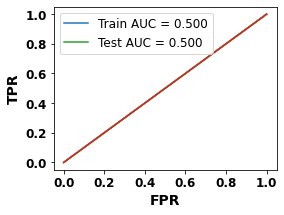

In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
fig = plt.figure(figsize = (4, 3))
fpr1,tpr1,_=roc_curve(np.argmax(trainY, axis=1),np.argmax(predIdxs, axis=1))
fpr2,tpr2,_=roc_curve(np.argmax(testY, axis=1),np.argmax(predIdys, axis=1))
area_under_curve1=auc(fpr1,tpr1)
random_probs=[0 for i in range(len(trainY.ravel()))]
p_fpr1,p_tpr1,threshold=roc_curve(trainY.ravel(),random_probs, pos_label=1)
plt.plot(fpr1,tpr1, label='Train AUC = {:.3f}'.format(area_under_curve1))
plt.plot(p_fpr1, p_tpr1)
area_under_curve2=auc(fpr2,tpr2)
random_probs2=[0 for i in range(len(testY.ravel()))]
p_fpr2,p_tpr2,threshold=roc_curve(testY.ravel(),random_probs2, pos_label=1)
plt.plot(fpr2,tpr2, label='Test AUC = {:.3f}'.format(area_under_curve2))
plt.plot(p_fpr2, p_tpr2)

    # x label
plt.xlabel('FPR',fontsize=14, fontdict=dict(weight='bold'))
    # y label
plt.ylabel('TPR', fontsize=14, fontdict=dict(weight='bold'))
plt.xticks( rotation=0, weight = 'bold', )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=12)
plt.tick_params(rotation=0,axis='x', labelsize=12)
plt.legend()
plt.legend(prop={'size':12})
plt.savefig('ROC',dpi=200, bbox_inches='tight')
plt.show();

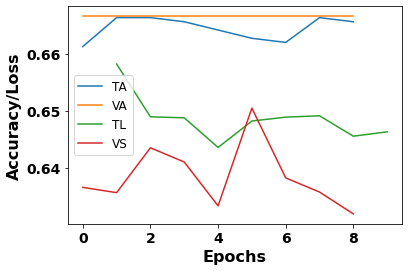

In [ ]:
#import seaborn as sns 
#plt.style.use('default') 
from matplotlib.ticker import FormatStrFormatter

#fig, ax = plt.subplots()
#fig = plt.figure(figsize = (4, 3))
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

N=len(H.history['loss'])
fig, ax = plt.subplots()
#plt.rcParams["font.family"] = "serif"
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
#font={'size':10}
#matplotlib.rc('font',**font)
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(np.arange(0, N), H.history["accuracy"], label="TA")
#plt.plot(epochs, loss, label='Training loss')
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="VA")
plt.plot(epochs, loss, label='TL')
#plt.plot(np.arange(0, N), H.history["val_accuracy"], label="validation accuracy")
plt.plot(np.arange(0, N), val_loss, label='VS')
#plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(1, val_acc, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs',fontsize=16, fontdict=dict(weight='bold'))
    # y label
plt.ylabel('Accuracy/Loss', fontsize=16, fontdict=dict(weight='bold'))
#plt.ylabel("Accuracy")
#plt.xlabel("Epochs")
plt.xticks( rotation=0, weight = 'bold' )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=14)
plt.tick_params(rotation=0,axis='x', labelsize=14)
#plt.grid('white')
#plt.grid(axis='x', color='0.95')
plt.legend(loc='best')
plt.legend(prop={'size':12})
#fig = plt.figure(figsize = (4, 3))
plt.savefig('ACC',dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
# import numpy as np
# import cv2
# from google.colab.patches import cv2_imshow
# from skimage import transform, io

# import skimage
# #xi = cv2.imread("/content/drive/MyDrive/monkeypox/gray/Monkeypox_gray/monkeypox00.jpg")
# #xi = cv2.imread("/content/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%0.png")

# Xi = io.imread("/content/drive/MyDrive/monkeypox/gray/Monkeypox_gray/monkeypox02.jpg")
# #Xi = skimage.io.imread("/content/drive/MyDrive/monkeypox/augmentedgray/Normal_image_gray_augmented/normalgray_aug105.jpg")

# #xi=cv2.resize(xi,(299,299))
# #cv2_imshow(xi/2+0.5)

# Xi = transform.resize(Xi, (299,299)) 

# Xi = (Xi - 0.5)*2 #Inception pre-processing

# skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing
# plt.xticks([])
# plt.yticks([])
# plt.show()

In [ ]:
# #Generate segmentation for image

# import skimage.segmentation
# Xi = skimage.transform.resize(Xi, (299,299,3)) 
# superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)

# num_superpixels = np.unique(superpixels).shape[0]

# skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))



# #Generate perturbations

# num_perturb = 150

# perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))



# #Create function to apply perturbations to images

# import copy

# def perturb_image(img,perturbation,segments): 

#   active_pixels = np.where(perturbation == 1)[0]

#   mask = np.zeros(segments.shape)

#   for active in active_pixels:

#       mask[segments == active] = 1 

#   perturbed_image = copy.deepcopy(img)

#   perturbed_image = perturbed_image*mask[:,:,np.newaxis]

#   return perturbed_image



# #Show example of perturbations

# print(perturbations[0]) 

# skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))
# plt.xticks([])
# plt.yticks([])
# plt.show()

In [ ]:
# from skimage import io
# from tensorflow.keras.preprocessing import image

# #url = '/content/drive/MyDrive/monkeypox/gray/Monkeypox_gray/monkeypox02.jpg'
# #url="/content/drive/MyDrive/monkeypox/mixed dataset/Other/measlesgray_aug254.jpg"
# #url="/content/drive/MyDrive/monkeypox/gray/Monkeypox_gray/monkeypox04.jpg"
# url="/content/drive/MyDrive/monkeypox/augmentedgray/Normal_image_gray_augmented/normalgray_aug105.jpg"

# def read_and_transform_img(url):

#     img = skimage.io.imread(url)
#     img = skimage.transform.resize(img, (224, 224,3))
    
#     img = image.img_to_array(img)
#     img = np.expand_dims(img, axis=0)

#     return img

# images = read_and_transform_img(url)

# preds = model.predict(images)
# prediction = np.argmax(preds)
# pct = np.max(preds)

# if prediction == 0:
#     print('It\'s a Monkeypox!')
# elif prediction == 1:
#     print('It\'s a others!')
# else:
#     print('Unable to predict!')

# print(pct)

In [ ]:
# pip install lime

In [ ]:
# from lime import lime_image

# explainer = lime_image.LimeImageExplainer()

In [ ]:
# explanation = explainer.explain_instance(images[0].astype('double'), model.predict,  
#                                          top_labels=3, hide_color=0, num_samples=200)

In [ ]:
# from skimage.segmentation import mark_boundaries

# temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
# temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,5))
# ax1.imshow(mark_boundaries(temp_1, mask_1))
# ax2.imshow(mark_boundaries(temp_2, mask_2))
# ax1.axis('off')
# ax2.axis('off')

In [ ]:
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# from scipy.ndimage import zoom
# from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
# img = cv2.imread('/content/drive/MyDrive/monkeypox/gray/Monkeypox_gray/monkeypox00.jpg')
# img = cv2.resize(img, (224, 224))
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# X = np.expand_dims(img, axis=0).astype(np.float32)
# X = preprocess_input(X)